### Работа с данными 
+ В **июле** провели специальную акцию, направленную на улучшение ретеншена. 
+ **Новым** юзерам слали письмо с купоном. 

#### Сработала ли акция?

In [291]:
# import
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tckr

In [292]:
# данных всего на 3Мб, легко забираем в оперативку
trans_data = pd.read_csv('analyst_test_transactions_db.csv')

In [293]:
# сделаем текст датами
trans_data.reg_date = pd.to_datetime(trans_data.reg_date)
trans_data.transaction_date = pd.to_datetime(trans_data.transaction_date)

In [294]:
# оценим временной горизонт
print('диапазон дат регистрации',
      date.strftime(min(trans_data.reg_date), '%Y-%m-%d'),
      '..', 
      date.strftime(max(trans_data.reg_date), '%Y-%m-%d'),
      )
print('диапазон дат транзакций ',
      date.strftime(min(trans_data.transaction_date), '%Y-%m-%d'),
      '..', 
      date.strftime(max(trans_data.transaction_date), '%Y-%m-%d'),
      )

диапазон дат регистрации 1900-01-01 .. 2015-11-20
диапазон дат транзакций  2015-01-01 .. 2015-11-20


### Уточним задачу
+ "новыми" будем считать всех пользователей, которые зарегистрировались в июле 2015
+ retention rate будем смотреть по месячным когортам, на основании данных по 10 полным месяцам 2015

In [295]:
# иллюстрация данных
trans_data.sample(5)

,user_id,order_id,reg_date,transaction_date,revenue
303,39466,94836.0,2015-03-14,2015-03-14,1465
56132,45456,198862.0,2012-07-22,2015-04-16,245
73016,92630,226986.0,2015-03-19,2015-07-13,1285
36247,35255,121256.0,2013-01-24,2015-06-13,825
68080,45991,144761.0,2012-11-08,2015-11-07,1389


In [296]:
# приcваиваем номер кагорты = номер месяца
trans_data['cohort_no'] = trans_data.reg_date.dt.month

# добавим год для наглядности - будем рассматривать пользователей только 2015
# и без транзакций в ноябре т.к. данные за ноябрь неполные
trans_data['reg_year'] = trans_data.reg_date.dt.year
trans_data['trans_month'] = trans_data.transaction_date.dt.month
trans_data = trans_data.query('reg_year==2015 & trans_month<11')

# по каждой транзакции добавляем разницу с месяцем регистрации
trans_data['cohort_lifetime'] = trans_data.transaction_date.dt.month - trans_data.reg_date.dt.month

In [297]:
# теперь сгруппируем по когортам, рассчитывая кол-во уникальных пользователей в них по "месяцам жизни"
# т.о. считаем уников с транзакциями
cohorts = trans_data\
        .groupby(['cohort_no','cohort_lifetime'])\
        .agg(total_user_id = ('user_id','nunique')).reset_index()

# для упрощения расчёта, "размножим" на весь фрейм данные по первому месяцу, 'cohort_lifetime' == 0
zero_cohorts_count = cohorts[cohorts['cohort_lifetime'] == 0][['cohort_no','total_user_id']]
zero_cohorts_count.columns = ['cohort_no', 'total_user_id_0']
cohorts = cohorts.merge(zero_cohorts_count, on='cohort_no')

# ура, добрались до retention rate
cohorts['retention'] = cohorts['total_user_id']/cohorts['total_user_id_0']

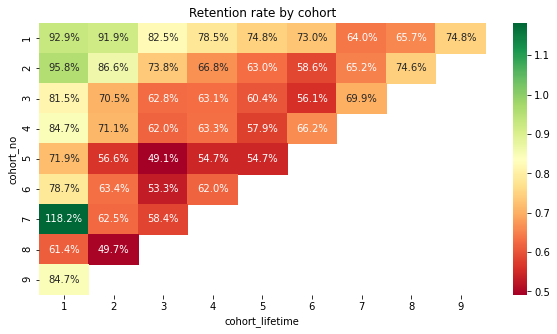

In [298]:
# отобразим метрику на hitmap
cohorts_pivot = cohorts\
        .pivot_table(
            index=cohorts['cohort_no'],
            columns='cohort_lifetime',
            values='retention',
            aggfunc='sum'
        )

plt.figure(figsize=(10, 5))
plt.title('Retention rate by cohort')
ax = sns.heatmap(
    cohorts_pivot.iloc[:-1,1:], 
    annot=True, fmt='.1%', cmap='RdYlGn'
)

### Очевидно, что акция принесла краткосрочный позитивный результат, отложенный на 1 месяц (см. 7 когорта, 1 месяц время жизни)
#### Количество пользователей, совершивших трансакции 
+ выше, чем в среднем в 1 "месяц жизни когорты"
+ рекордно выше 100% по отношению к нулевому "месяцу жизни когорты"

### Однако, в последствии метрика для 7 когорты "испортилась"

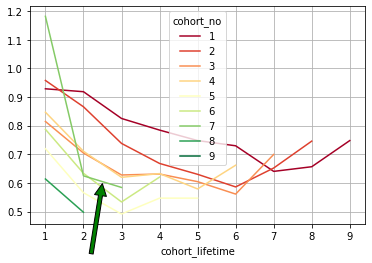

In [299]:
ax = cohorts_pivot.T.iloc[1:,:-1].plot(cmap='RdYlGn', grid=True)
ax.annotate('',xy=(2.5, 0.6),
            xytext=(2.2, 0.35),
            arrowprops=dict(facecolor='green', shrink=0.01),
            horizontalalignment='right', verticalalignment='top');

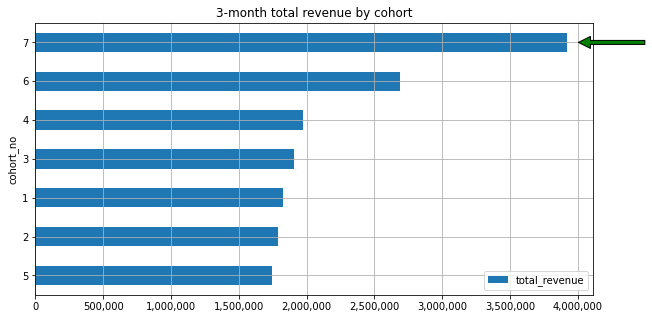

In [300]:
# сравним суммарную выручку по 1-7 кагортам за 3 месяца
ax = trans_data.query('cohort_no<8 & cohort_lifetime<4')\
    .groupby('cohort_no').agg(total_revenue=('revenue', 'sum'))\
    .sort_values(by='total_revenue')\
    .plot.barh(title='3-month total revenue by cohort', figsize=(10,5), grid=True)
ax.xaxis.set_major_formatter(tckr.StrMethodFormatter('{x:,.0f}'))
ax.annotate('',xy=(4000000, 6),
            xytext=(4500000, 6),
            arrowprops=dict(facecolor='green', shrink=0.01),
            horizontalalignment='right', verticalalignment='top');

# Окончательный вывод: aкция сработала 
+ на следующий месяц после акции получили рекордный в 2015 retention rate
+ кроме того, также зафиксирована рекордная сумма транзакций по первым 3 месяцам пользования сервисом 